In [26]:
from data_loader import Data_Loader
import pm4py

num = 1
path = f'/Users/philippeichhorn/Downloads/Compositional process discovery_experiment data/IP-{num}/IP-{num}_initial_log.xes'
list_of_nets = Data_Loader.create_petri_nets(path)


parsing log, completed traces ::   0%|          | 0/5000 [00:00<?, ?it/s]

In [46]:
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils import petri_utils

def remove_local_transition(net, transition):
    if len(transition.in_arcs) == 1 and len(transition.out_arcs) == 1:
        place_before_transition = list(transition.in_arcs)[0].source  # will be removed
        if len(place_before_transition.in_arcs) == 1 and len(place_before_transition.out_arcs) == 1:
            first_transition = list(place_before_transition.in_arcs)[0].source  # will point to last place
            place_after_transition = list(transition.out_arcs)[0].target #gets pointed from first_transition
            if (len(place_after_transition.in_arcs)== 1):
                petri_utils.add_arc_from_to(first_transition, place_after_transition, net)
                print("added one arc to: ")
                print(transition.label)
                petri_utils.remove_transition(net, transition)
                petri_utils.remove_place(net, place_before_transition)

                return True

    return False


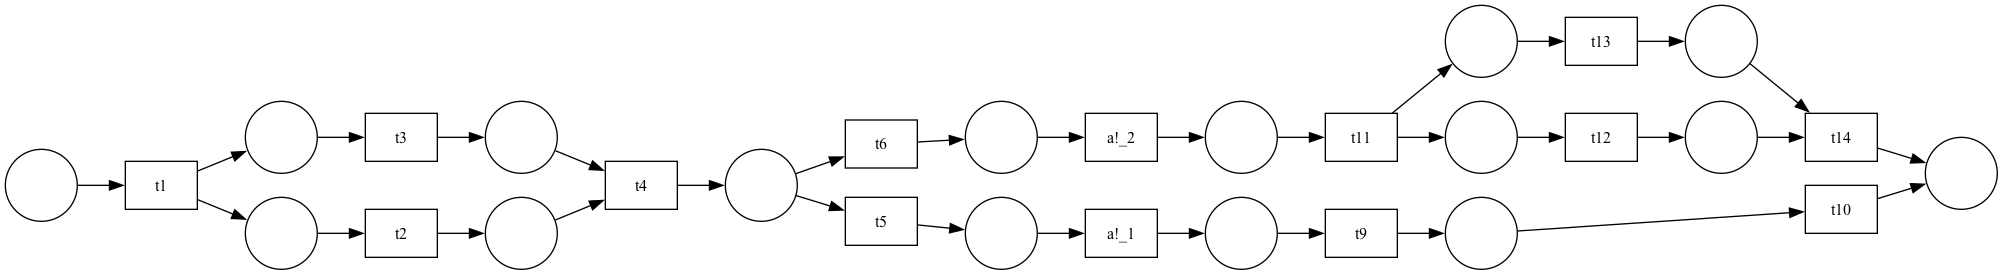

added one arc to: 
t13
added one arc to: 
a!_2
added one arc to: 
t3
added one arc to: 
t2
added one arc to: 
a!_1
added one arc to: 
t9
added one arc to: 
t12


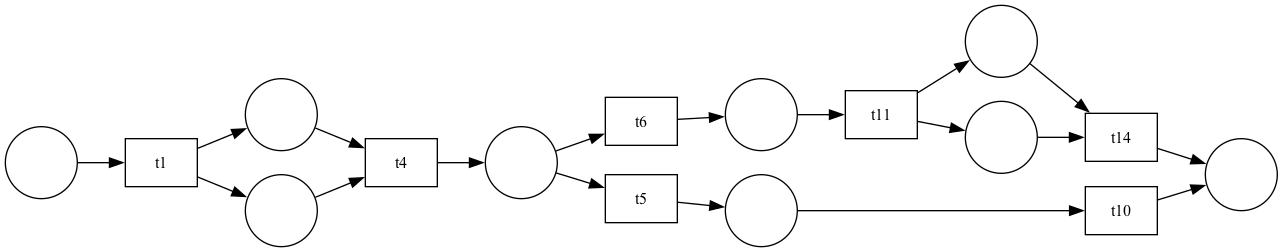

In [48]:
from copy import deepcopy

for net in list_of_nets:
    pnet, start, end = net
    pnet = deepcopy(pnet)
    pm4py.view_petri_net(pnet, start, end, format="png")

    for transition in pnet.transitions.copy():
        remove_transition(pnet, transition)
        
    pm4py.view_petri_net(pnet, start, end, format="png")
    break